Step 1:
From various bank applications/ pdfs, convert the expenses to csv file of the format:
Date | Description of expense | Amount | Card

Step 2:

From a csv file, convert data into categories and sub categories. 
Date | Description | Amount | Card | Category | Sub Category


In [ ]:
!pip install rapidfuzz

In [10]:
# all imports
import pandas as pd 
import numpy as np 
import re
from collections import Counter, defaultdict
from typing import Dict, Tuple, Optional, List
from rapidfuzz import process, fuzz # pip install rapidfuzz
import matplotlib.pyplot as plt
import os
import parse_statement
# display related imports
from IPython.display import display, HTML, clear_output
import ipywidgets as W
from datetime import datetime


In [11]:
# helper functions
def standardize_cols(df: pd.DataFrame) -> pd.DataFrame:
	lower_map = {c: c.strip().lower() for c in df.columns}
	df = df.rename(columns=lower_map)
	# # normalize common variants
	# if "sub_category" in df.columns and "sub-category" not in df.columns:
	# 	df = df.rename(columns={"sub_category": "sub-category"})
	return df
def normalize(text: str) -> str:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    t = text.strip().lower()
    t = re.compile(r"[^\w\s]").sub(" ", t)         # remove punctuation
    t = re.compile(r"\s+").sub(" ", t)         # collapse spaces
    return t.strip()

def most_common_pair(pairs: List[Tuple[str, str]]) -> Tuple[Optional[str], Optional[str]]:
    if not pairs:
        return None, None
    counter = Counter(pairs)
    (cat, subcat), _ = counter.most_common(1)[0]
    return cat, subcat

def build_description_lookup(dest_df: pd.DataFrame) -> Dict[str, Tuple[Optional[str], Optional[str]]]:
    # Group by normalized description and take the most common (category, sub-category) pair
    pairs_by_desc: Dict[str, List[Tuple[str, str]]] = defaultdict(list)
    for _, row in dest_df.iterrows():
        nd = normalize(row.get("description", ""))
        cat = row.get("category")
        sub = row.get("sub-category") if "sub-category" in row else row.get("sub_category")
        if pd.notna(cat) and pd.notna(sub):
            pairs_by_desc[nd].append((str(cat), str(sub)))
    lookup: Dict[str, Tuple[Optional[str], Optional[str]]] = {}
    for nd, pairs in pairs_by_desc.items():
        lookup[nd] = most_common_pair(pairs)
    return lookup

def fuzzy_best_match(query: str, choices: List[str], threshold: int = 90) -> Tuple[Optional[str], float]:
    if not choices:
        return None, 0.0
       # Using token_set_ratio helps with word order/duplication
    match = process.extractOne(query, choices, scorer=fuzz.token_set_ratio)
    if match is None:
        return None, 0.0
    choice, score, _ = match
    return choice, float(score)
    

In [12]:
# # code to sort categories and sub categories for description
# df = pd.read_csv("references.csv")
# df = df.drop_duplicates()
# df = df.sort_values(by=["category", "sub-category", "description"], ascending=[True, True, True])
# df = df.reset_index(drop=True)
# df.to_csv("updated_references.csv", index=False)
# print(df.head())

      Description       Category sub-category
0   Arena Tickets  Entertainment       Events
1   City Concerts  Entertainment       Events
2   Festival Pass  Entertainment       Events
3         GameHub  Entertainment        Games
4  JoyStick Arena  Entertainment        Games


In [12]:
# read csv source file and convert data to dataframe
# source_file = "Source_200.csv"
# src = standardize_cols(pd.read_csv(source_file))
# required_src = {"date", "description", "amount", "card"}
# if not required_src.issubset(set(src.columns)):
#     raise ValueError(f"Source file must contain columns {required_src}. Found: {list(src.columns)}")
# src.head()

relative_path = 'Source files'
absolute_path = os.path.abspath(relative_path)
print(absolute_path)
patterns_file = "Patterns.csv"
# Collect all CSV file paths
csv_files = [os.path.join(absolute_path, f) for f in os.listdir(absolute_path) if f.lower().endswith(".csv")]

# Read and combine
df_list = []
for file in csv_files:
    df = parse_statement.parse_statement_file(file, patterns_file)
    temp_df = standardize_cols(df)
    temp_df["source_file"] = os.path.basename(file)   # optional: track origin
    required_src = {"date", "description", "amount", "card"}
    if not required_src.issubset(set(temp_df.columns)):
        raise ValueError(f"Source file must contain columns {required_src}. Found: {list(temp_df.columns)}")
    df_list.append(temp_df)

# Concatenate into one unified DataFrame
src = pd.concat(df_list, ignore_index=True)

print(f" Loaded {len(csv_files)} files with {len(src)} total rows")
src.head()

c:\Users\swapn\OneDrive\Desktop\Desktopp\Fun\Budgetapp\Source files


ValueError: No matching pattern found for c:\Users\swapn\OneDrive\Desktop\Desktopp\Fun\Budgetapp\Source files\Source_200.csv

In [4]:
# read reference file to match data to categories and sub-categories
referene_file = "updated_references.csv" 
ref = standardize_cols(pd.read_csv(referene_file))
required_ref = { "description", "category", "sub-category"}
if not required_ref.issubset(set(ref.columns)):
    missing = required_ref - set(ref.columns)
    raise ValueError(f"Destination file missing required columns: {missing}")
ref.head()

,description,category,sub-category
0,Arena Tickets,Entertainment,Events
1,City Concerts,Entertainment,Events
2,Festival Pass,Entertainment,Events
3,GameHub,Entertainment,Games
4,JoyStick Arena,Entertainment,Games


In [5]:
# Build lookup for exact description -> (category, subcat)
desc_to_pair = build_description_lookup(ref)
all_choices = list(desc_to_pair.keys())
suggestions = []
# fuzzy logic to categorize expenses
for _, row in src.iterrows():
        nd = normalize(row["description"])
        cat = None
        sub = None
        match_type = "none"
        match_desc = None
        match_score = 0.0

        # Exact
        if nd in desc_to_pair and all(v is not None for v in desc_to_pair[nd]):
            cat, sub = desc_to_pair[nd]
            match_type = "exact"
            match_desc = nd
            match_score = 100.0
        else:
            # Fuzzy
            best, score = fuzzy_best_match(nd, all_choices, threshold=90)
            if best is not None and score >= 90 and all(v is not None for v in desc_to_pair.get(best, (None, None))):
                cat, sub = desc_to_pair[best]
                match_type = "fuzzy"
                match_desc = best
                match_score = score

        suggestion = {
            "date": row.get("date"),
            "description": row.get("description"),
            "amount": row.get("amount"),
            "card": row.get("card"),
            "category": cat,
            "sub-category": sub,
            "match_type": match_type,
            "matched_description_norm": match_desc,
            "match_score": round(match_score, 1),
            "needs_review": match_type != "exact",  # review fuzzy and none
            "reason": "exact" if match_type == "exact" else ("fuzzy_suggest" if match_type == "fuzzy" else "no_match"),
        }
        suggestions.append(suggestion)

suggest_df = pd.DataFrame(suggestions)

suggest_df.head()


,date,description,amount,card,category,sub-category,match_type,matched_description_norm,match_score,needs_review,reason
0,11/6/2024,Style Street,186.58,Visa,Merchandise,Clothing,exact,style street,100.0,False,exact
1,3/16/2024,FreshMart,39.69,Visa,Food,Groceries,exact,freshmart,100.0,False,exact
2,8/21/2024,SoundWave,258.85,Mastercard,Entertainment,Music,exact,soundwave,100.0,False,exact
3,2/21/2024,Harbor Inn,338.20,Visa,Travel & Housing,Lodging,exact,harbor inn,100.0,False,exact
4,10/14/2024,GoCab,227.66,Amex,Travel & Housing,Rideshare,exact,gocab,100.0,False,exact


In [6]:
# explore needed more review records.
needed_review_df = suggest_df[suggest_df["needs_review"] == True]
needed_review_df.count()

date                        51
description                 51
amount                      51
card                        51
category                     1
sub-category                 1
match_type                  51
matched_description_norm     1
match_score                 51
needs_review                51
reason                      51
dtype: int64

In [11]:
# Save all rows with suggestions
# merged_path = os.path.join(args.output_dir, "merged_with_suggestions.csv")
# suggest_df.to_csv(merged_path, index=False)

# # Save rows needing review
# to_review = suggest_df[suggest_df["needs_review"]].copy()
# # Provide empty columns for user to fill/override
# to_review["category_final"] = to_review["category"]
# to_review["sub-category_final"] = to_review["sub-category"]
# review_path = os.path.join(args.output_dir, "to_review.csv")
# to_review.to_csv(review_path, index=False)


✅ Removed duplicates and sorted by category.
      Description       Category sub-category
0   Arena Tickets  Entertainment       Events
1   City Concerts  Entertainment       Events
2   Festival Pass  Entertainment       Events
3         GameHub  Entertainment        Games
4  JoyStick Arena  Entertainment        Games


Step 3:
We visualize this data on dashboards.


In [7]:

reviewed_df = suggest_df[suggest_df["needs_review"] == False]
reviewed_df.head()

,date,description,amount,card,category,sub-category,match_type,matched_description_norm,match_score,needs_review,reason
0,11/6/2024,Style Street,186.58,Visa,Merchandise,Clothing,exact,style street,100.0,False,exact
1,3/16/2024,FreshMart,39.69,Visa,Food,Groceries,exact,freshmart,100.0,False,exact
2,8/21/2024,SoundWave,258.85,Mastercard,Entertainment,Music,exact,soundwave,100.0,False,exact
3,2/21/2024,Harbor Inn,338.20,Visa,Travel & Housing,Lodging,exact,harbor inn,100.0,False,exact
4,10/14/2024,GoCab,227.66,Amex,Travel & Housing,Rideshare,exact,gocab,100.0,False,exact


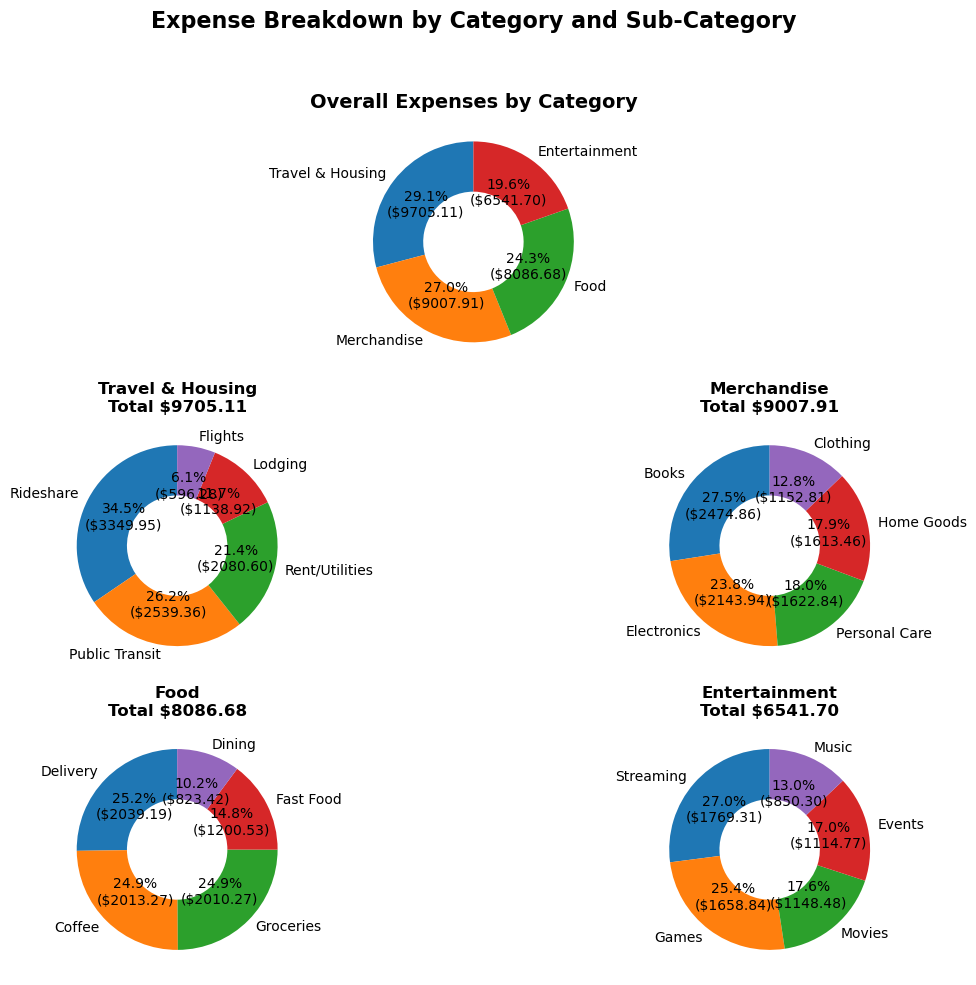

In [8]:
# Compute totals
cat_totals = reviewed_df.groupby("category")["amount"].sum().sort_values(ascending=False)
subcat_totals = reviewed_df.groupby(["category", "sub-category"])["amount"].sum()

# --- Prepare Figure ---
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2)  # 3 rows, 2 cols grid
axes = []

# Top categories (up to 4 for 2x2 grid)
top_categories = cat_totals.head(4).index.tolist()

# Main overall pie chart (top row, spanning both columns)
ax_main = fig.add_subplot(gs[0, :], aspect='equal')
wedges, texts, autotexts = ax_main.pie(
    cat_totals,
    labels=cat_totals.index,
    autopct=lambda p: f'{p:.1f}%\n(${p*cat_totals.sum()/100:.2f})',
    startangle=90,
    wedgeprops=dict(width=0.5)
)
ax_main.set_title("Overall Expenses by Category", fontsize=14, fontweight='bold')

# Subcategory pies (2x2 grid below)
for i, cat in enumerate(top_categories):
    row = 1 + i // 2   # Rows 1,2 (since row 0 is main chart)
    col = i % 2
    ax = fig.add_subplot(gs[row, col], aspect='equal')
    subs = subcat_totals.loc[cat].sort_values(ascending=False)

    wedges, texts, autotexts = ax.pie(
        subs,
        labels=subs.index,
        autopct=lambda p: f'{p:.1f}%\n(${p*subs.sum()/100:.2f})',
        startangle=90,
        wedgeprops=dict(width=0.5)
    )
    ax.set_title(f"{cat}\nTotal ${subs.sum():.2f}", fontsize=12, fontweight='bold')

# --- Layout and show ---
plt.suptitle("Expense Breakdown by Category and Sub-Category", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("output.png")

plt.show()
